# **PySpark: Stack Overflow Tag Co-occurrence Networks**

In [1]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import re
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import distutils
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

## **Getting Started**

In [3]:
spark_jars_dir = os.path.join(os.path.dirname(pyspark.__file__), "jars")
print(f"Spark jars directory: {spark_jars_dir}")

Spark jars directory: /usr/local/lib/python3.11/dist-packages/pyspark/jars


In [4]:
# Download the connector JAR to the Spark jars directory
!wget -q https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar -P {spark_jars_dir}

In [5]:
# Create Spark session
spark = SparkSession.builder \
    .appName("Read GCS Parquet") \
    .config("spark.jars", "gcs-connector-hadoop3-latest.jar") \
    .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.fs.gs.auth.type", "NONE") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "false") \
    .config("spark.hadoop.fs.gs.project.id", "") \
    .config("spark.hadoop.google.cloud.auth.null.enable", "true") \
    .getOrCreate()

In [ ]:
posts_df = spark.read.parquet("gs://rotman-data/so-small/posts.parquet")
tags_df = spark.read.parquet("gs://rotman-data/so-small/tags.parquet")

In [ ]:
tags_df.show(5)

+-------+--------------+---+----------+-----------+
| _Count|_ExcerptPostId|_Id|  _TagName|_WikiPostId|
+-------+--------------+---+----------+-----------+
| 341481|       3624959|  1|      .net|    3607476|
|1191229|       3673183|  2|      html|    3673182|
|2537512|       3624960|  3|javascript|    3607052|
| 808824|       3644670|  4|       css|    3644669|
|1469725|       3624936|  5|       php|    3607050|
+-------+--------------+---+----------+-----------+
only showing top 5 rows



In [ ]:
posts_df.show(5)

+-----------------+------------+--------------------+-----------+-------------+-------------------+---------------+--------------------+------+--------------------+--------------------+----------------------+-----------------+-----------------+------------+---------+-----------+------+-----+------+----------+
|_AcceptedAnswerId|_AnswerCount|               _Body|_ClosedDate|_CommentCount|_CommunityOwnedDate|_ContentLicense|       _CreationDate|   _Id|   _LastActivityDate|       _LastEditDate|_LastEditorDisplayName|_LastEditorUserId|_OwnerDisplayName|_OwnerUserId|_ParentId|_PostTypeId|_Score|_Tags|_Title|_ViewCount|
+-----------------+------------+--------------------+-----------+-------------+-------------------+---------------+--------------------+------+--------------------+--------------------+----------------------+-----------------+-----------------+------------+---------+-----------+------+-----+------+----------+
|             NULL|        NULL|<p>Since your fir...|       NULL|  

## **Tag Co-occurrence Networks**
Which technologies are most commonly used together, and what distinct technology ecosystems can be identified from tag co-occurrence patterns?

### **Step 1: Data Preparation**
Create a dataframe containing all questions with their tag lists.

In [ ]:
# udf: User-defined function
# Extract tags from a tag string and convert it into a list of individual tags
def extract_tags(tags_string):
  if not tags_string:
    return []
  return re.findall(r'<([^>]+)>', tags_string)

extract_tags_udf = F.udf(extract_tags, F.ArrayType(F.StringType()))

In [ ]:
# only question posts have tags (PostTypeId = 1)
questions_with_tags = posts_df.filter(F.col("_PostTypeId") == 1).withColumn("_TagList",
                                                                          extract_tags_udf(F.col("_Tags")))

In [ ]:
# The tag list looks like:
questions_with_tags.take(1)[0]._TagList

['c++', 'qt', 'syntax-highlighting', 'qpainter']

### **Step 2: Tag Pairs**
Create a table containing tag pairs.

Remove duplicates:
- Eliminate tag pairs with identical tags.
- Keep only one pair for tags that appear in reverse order (e.g., (tag1, tag2) and (tag2, tag1)).

In [ ]:
tag_pairs = questions_with_tags.select(
            F.explode(F.col("_TagList")).alias("tag1"),
            F.explode(F.col("_TagList")).alias("tag2"),
            ).filter(F.col("tag1") < F.col("tag2"))

Extract all tags and their corresponding counts from `tags_df`.

In [ ]:
single_tag_counts = tags_df.select(
    F.col('_TagName').alias("tag"),
    F.col('_Count').alias("tag_count")
)

### **Step 3: Co-occurrence Count**
Count the number of posts where both tags appear.
Resulting table:
- Each row is a unique tag pair.
- `co_occurrence_count`: number of posts where both tags appear

In [ ]:
tag_pair_counts = tag_pairs.groupBy("tag1", "tag2").agg(
    F.count("*").alias("co_occurrence_count")
)

Integrate the co-occurrence count with single tag counts

In [ ]:
count_results = tag_pair_counts \
    .join(single_tag_counts.alias('tag1_counts'),
          tag_pair_counts['tag1'] == F.col('tag1_counts.tag')) \
    .join(single_tag_counts.alias('tag2_counts'),
          tag_pair_counts['tag2'] == F.col('tag2_counts.tag')) \
    .select(
        'tag1', 'tag2',
        'co_occurrence_count',
        F.col('tag1_counts.tag_count').alias('tag1_count'),
        F.col('tag2_counts.tag_count').alias('tag2_count')
    )

In [ ]:
count_results.show(5)

+---------------+--------------------+-------------------+----------+----------+
|           tag1|                tag2|co_occurrence_count|tag1_count|tag2_count|
+---------------+--------------------+-------------------+----------+----------+
|              c|            wireless|                  3|    408021|       688|
|  configuration|continuous-integr...|                  3|     18286|     14155|
|category-theory|             haskell|                 26|       431|     51622|
|        caching|         inputstream|                  1|     38559|      4399|
|             c#|          javascript|               2755|   1626156|   2537512|
+---------------+--------------------+-------------------+----------+----------+
only showing top 5 rows



### **Step 4: Similarity Score**
Calculate similarity scores between the two tags based on intersection / union of posts.

**Jaccard similarity** is used:

- Numerator: co_occurrence_count, which represents the number of posts that contain both tags (the intersection).

- Denominator: tag1_count + tag2_count - co_occurrence_count, which represents the total number of unique posts containing either tag (the union).

In [ ]:
similarity_results = count_results.withColumn(
    "similarity", count_results["co_occurrence_count"] /
    (count_results["tag1_count"] + count_results["tag2_count"] - count_results["co_occurrence_count"])
)

In [ ]:
similarity_results.show(2)

+-------------+--------------------+-------------------+----------+----------+--------------------+
|         tag1|                tag2|co_occurrence_count|tag1_count|tag2_count|          similarity|
+-------------+--------------------+-------------------+----------+----------+--------------------+
|            c|            wireless|                  3|    408021|       688|7.340239683293125E-6|
|configuration|continuous-integr...|                  3|     18286|     14155|9.248412355878907E-5|
+-------------+--------------------+-------------------+----------+----------+--------------------+
only showing top 2 rows



### **Step 5: Clean the Results**
Put `co_occurrence_count` and `similarity` into one table.

In [ ]:
final_results = similarity_results.select("tag1", "tag2", "co_occurrence_count", "similarity")

In [ ]:
final_results.printSchema()

root
 |-- tag1: string (nullable = true)
 |-- tag2: string (nullable = true)
 |-- co_occurrence_count: long (nullable = false)
 |-- similarity: double (nullable = true)



In [ ]:
# Convert the final results into a Pandas DataFrame for further analysis and visualization
final_df = final_results.toPandas()

In [ ]:
final_df.head()

,tag1,tag2,co_occurrence_count,similarity
0,c,wireless,3,0.000007
1,configuration,continuous-integration,3,0.000092
2,category-theory,haskell,26,0.000500
3,caching,inputstream,1,0.000023
4,c#,javascript,2755,0.000662


In [ ]:
# the resulting df has around 145K rows, with each row representing a unique tag pair
final_df.shape

(1448328, 4)

### **Step 6: Intreprete the Results**

#### **6.1 Top 30 Most Strongly Connected Tag Pairs**
A list of the top 30 most strongly connected tag pairs, ranked by similarity


In [ ]:
final_df.sort_values(by='similarity', ascending=False).head(30)

,tag1,tag2,co_occurrence_count,similarity
1447689,android-xr,scenecore,1,1.000000
702990,fabric-lakehouse,fabric-warehouse,1,1.000000
331360,appenvoy,mobileposse,1,1.000000
1022707,compress4j,jarchivelib,1,1.000000
1024386,isolated-context,rebrowser,1,1.000000
1079835,mutablemapping,shadowsocks,1,1.000000
453734,harvester,harvester-hci,1,1.000000
1444134,node-ottoman,ottoman,1,1.000000
1335487,ton-gas,tvm-ton,1,0.500000
573569,field-device-tool,xdr-schema,1,0.500000


**Keep tag pairs with at least 500 co-occurrence counts.**

In [ ]:
final_df_500 = final_df[final_df['co_occurrence_count'] >= 500]

In [ ]:
# The number of tag pairs is reduced to 1452
final_df_500.shape

(1452, 4)

In [ ]:
final_df_500.sort_values(by='similarity', ascending=False).head(30)

,tag1,tag2,co_occurrence_count,similarity
560419,excel,vba,15856,0.032260
586534,dart,flutter,7980,0.029625
1128315,cypher,neo4j,902,0.028108
1118622,css,html,48959,0.025093
1134456,dax,powerbi,751,0.024953
22283,google-apps-script,google-sheets,2630,0.023975
1118791,jsf,primefaces,1199,0.022244
1121164,actionscript-3,flash,1650,0.022193
27255,discord,discord.py,782,0.021456
580328,dataframe,pandas,8925,0.020836


#### **6.2 Technology Clusters with Core and Peripheral Technologies**
A visualization showing 6 identified technology clusters with their core and peripheral technologies.

Build a network graph where each technology (tag) is a node, and the edges represent co-occurrence between tags. The edge weight is based on **similarity score**.

In [ ]:
G = nx.Graph()

# Add nodes (tags)
for _, row in final_df_500.iterrows():
  G.add_node(row['tag1'])
  G.add_node(row['tag2'])
  G.add_edge(row['tag1'], row['tag2'], weight=row['similarity'])

Calculate **Core vs Peripheral Technologies** based on degree centrality. Core technologies are nodes with more than 0.1 centrality.

In [ ]:
# Compute degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Identify core technologies (higher centrality) and peripheral ones (lower centrality)
core_technologies = {node for node, centrality in degree_centrality.items() if centrality > 0.1}
peripheral_technologies = set(G.nodes) - core_technologies

For each core technology, retain the **top 30 peripheral technologies** based on similarity to create technology clusters.

In [ ]:
def display_top30_peripheral(core_tech):

  # get all edges connected to the core technology
  edges = [(core_tech, neighbor,
            G[core_tech][neighbor]['weight']) for neighbor in G.neighbors(core_node)]

  # Sort edges by similarity score (weight) in descending order and select the top 30
  top_30_edges = sorted(edges, key=lambda x: x[2], reverse=True)[:30]

  # neighbors from top 30 edges
  top_nodes = [edge[1] for edge in top_30_edges]

  return top_nodes

Helper function to visualize a technology cluster (core technology + top 30 peripheral technologies)

In [ ]:
def visualize_network(core_node):

    subgraph = G.subgraph([core_node] + display_top30_peripheral(core_node))

    # Position the nodes using spring layout
    pos = nx.spring_layout(subgraph)

    # Draw the network
    nx.draw_networkx_nodes(subgraph, pos, node_color="lightgray", node_size=500, ax=ax, node_shape='D')
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[core_node], node_color="orange", node_size=2000, ax=ax)
    nx.draw_networkx_labels(subgraph, pos, font_size=11, ax=ax)

    ax.set_title(f"Core Technology: {core_node.upper()}", fontweight='bold')
    ax.axis('off')

In [ ]:
core_technologies = list(core_technologies)
core_technologies

['android', 'java', 'javascript', 'php', 'c#', 'python']

##### **Core Technology: Android**
The identified technology cluster centers around Android, with peripheral technologies such as Android Layout, Android Studio, flutter and others.



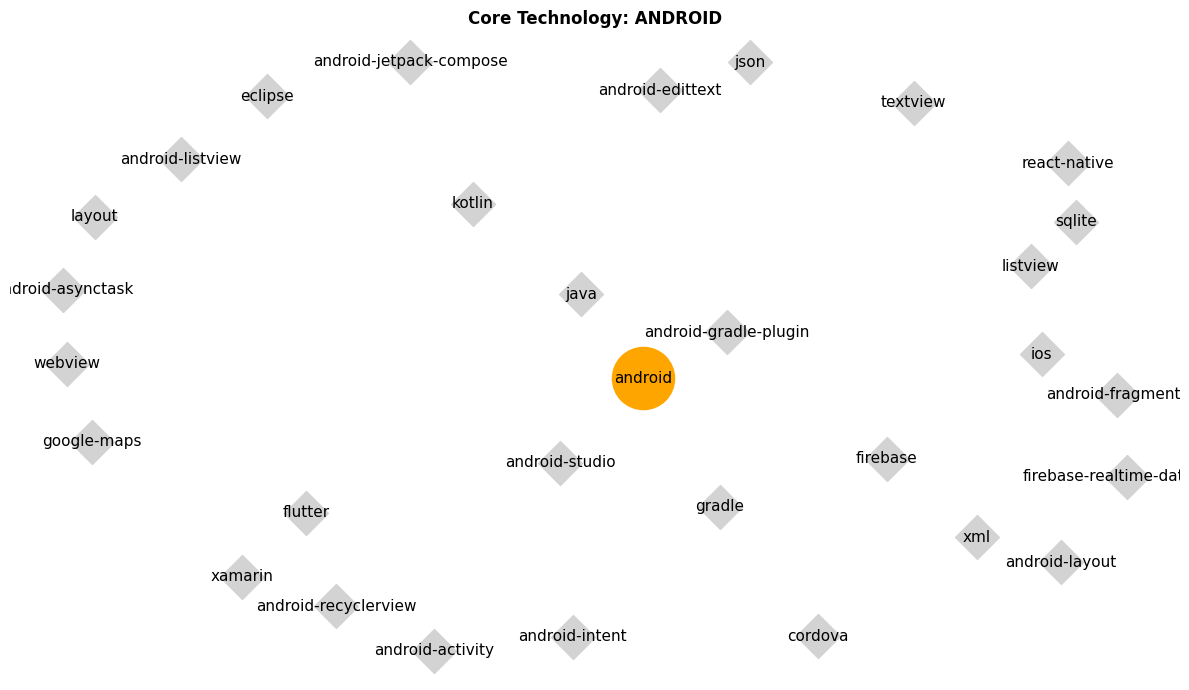

In [ ]:
core_node = core_technologies[0]
fig, ax = plt.subplots(figsize=(12, 7))
visualize_network(core_node)
plt.tight_layout()
plt.show()

##### **Core Technology: Java**
The identified technology cluster centers around Java, with peripheral technologies such as spring-boot, xml, Android and others.

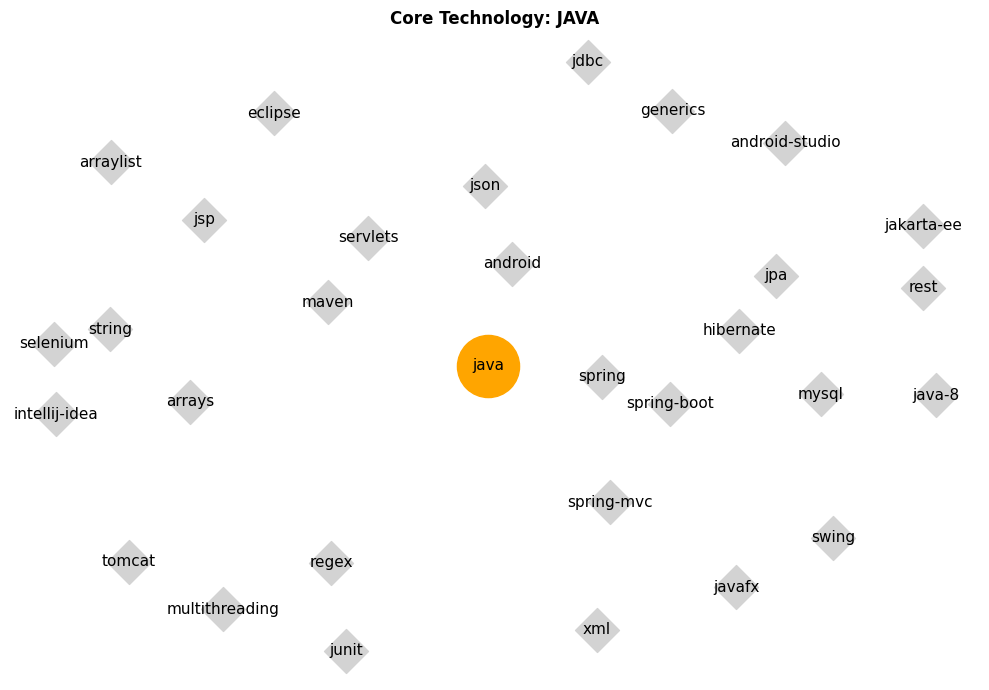

In [ ]:
core_node = core_technologies[1]
fig, ax = plt.subplots(figsize=(10, 7))
visualize_network(core_node)
plt.tight_layout()
plt.show()

##### **Core Technology: Javascript**
The identified technology cluster centers around Javascript, with peripheral technologies such as html, jquery, ajax and others.

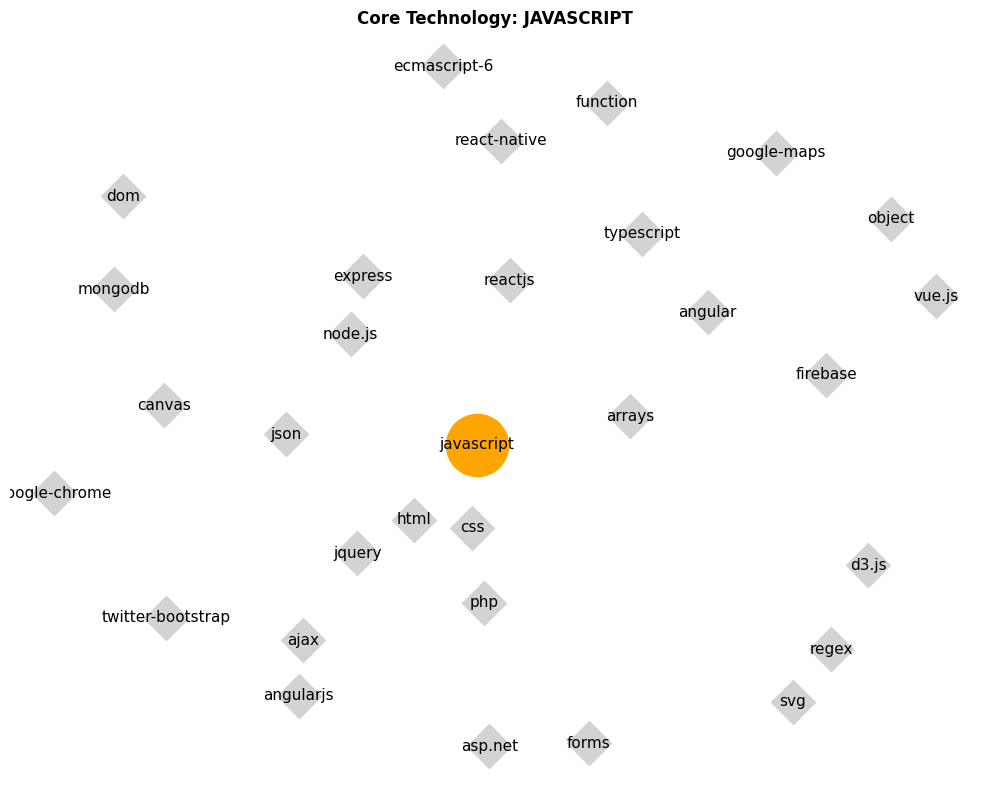

In [ ]:
core_node = core_technologies[2]
fig, ax = plt.subplots(figsize=(10, 8))
visualize_network(core_node)
plt.tight_layout()
plt.show()

##### **Core Technology: PHP**

The identified technology cluster centers around PHP, with peripheral technologies such as ajax, jquery, arrays and others.

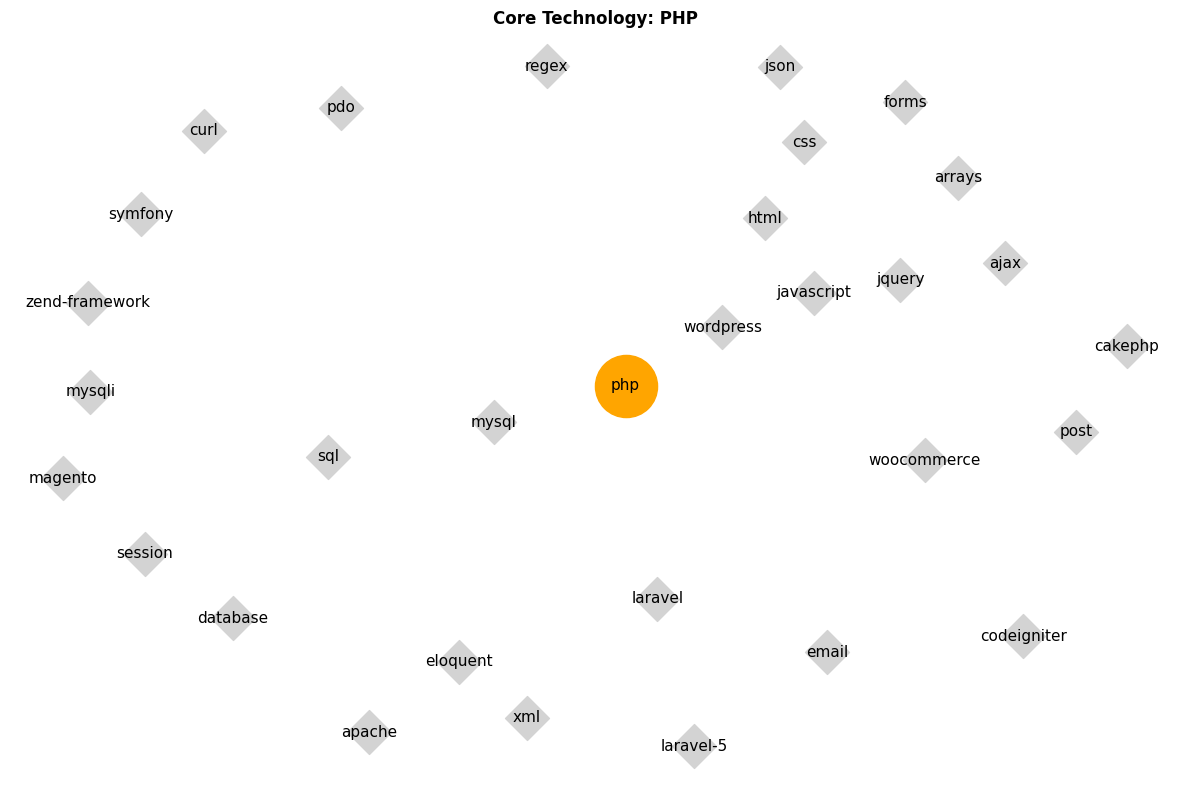

In [ ]:
core_node = core_technologies[3]
fig, ax = plt.subplots(figsize=(12, 8))
visualize_network(core_node)
plt.tight_layout()
plt.show()

##### **Core Technology: C#**

The identified technology cluster centers around C#, with peripheral technologies such as asp.net-mvc, arrays and others.

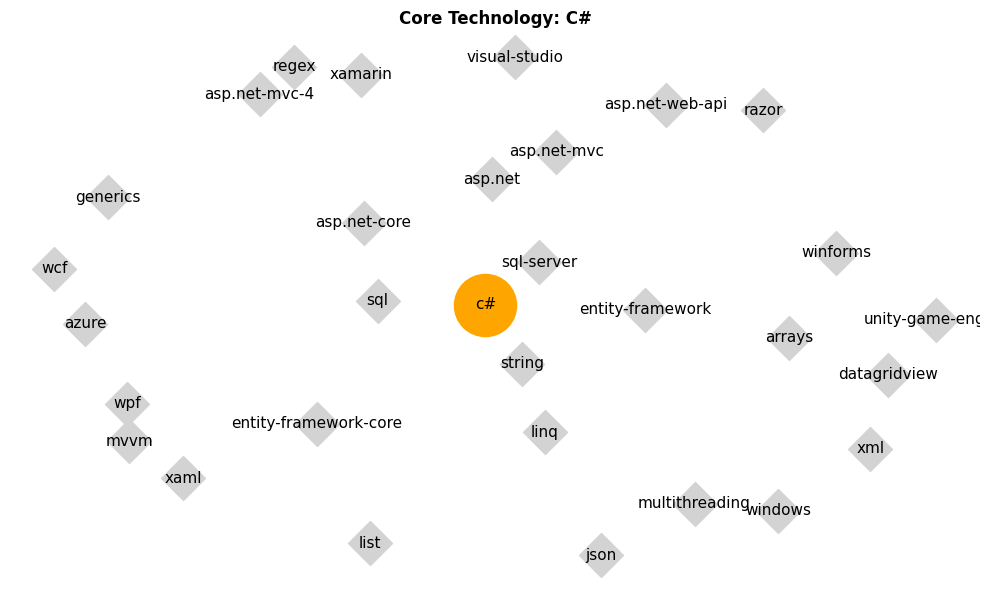

In [ ]:
core_node = core_technologies[4]
fig, ax = plt.subplots(figsize=(10, 6))
visualize_network(core_node)
plt.tight_layout()
plt.show()

##### **Core Technology: Python**

The identified technology cluster centers around Python, with peripheral technologies such as machine-learning, arrays, scikit-learn, numpy and others.

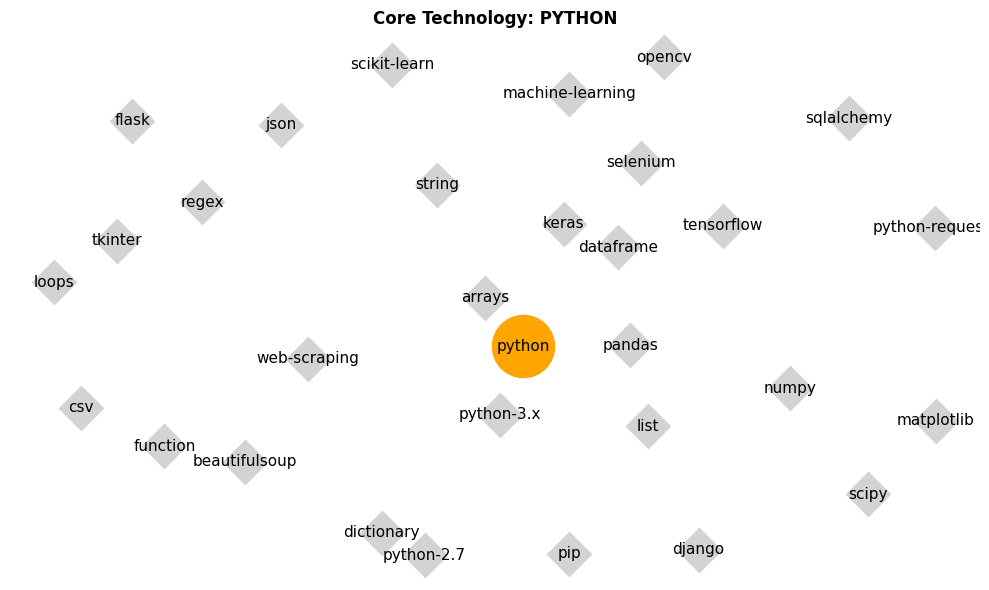

In [ ]:
core_node = core_technologies[5]
fig, ax = plt.subplots(figsize=(10, 6))
visualize_network(core_node)
plt.tight_layout()
plt.show()